In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2

In [2]:
from PIL import Image
from sklearn.model_selection import train_test_split
import random
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt

2024-04-25 06:09:18.552999: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 06:09:18.553135: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 06:09:18.687481: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
dataset_dir = "/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database"
normal_dir = os.path.join(dataset_dir, "Normal")
tuberculosis_dir = os.path.join(dataset_dir, "Tuberculosis")

In [4]:
def preprocess_images(image_dir, label):
    images = []
    labels = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".png"):
            image_path = os.path.join(image_dir, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.equalizeHist(image)
            image = cv2.resize(image,(256, 256))  # Resize images to 256x256 pixels
            image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
            image = np.array(image) / 255.0   # Normalize pixel values to [0, 1]

            images.append(image)
            labels.append(label)
    return images, labels

In [5]:
# Load and preprocess normal images
normal_images, normal_labels = preprocess_images(normal_dir, label=0)
# Load and preprocess tuberculosis images
tuberculosis_images, tuberculosis_labels = preprocess_images(tuberculosis_dir, label=1)

In [6]:
# Combine normal and tuberculosis images
images = normal_images + tuberculosis_images
labels = normal_labels + tuberculosis_labels

In [7]:
images = np.array(images)
labels = np.array(labels)

In [8]:
df1=pd.read_csv('/kaggle/input/tuberculosis-chest-xrays-shenzhen/shenzhen_metadata.csv')
base_path='/kaggle/input/tuberculosis-chest-xrays-shenzhen/images/images/'
df1['equalized_filename'] = df1['study_id'].apply(lambda x: base_path+x)
df2=pd.read_csv('/kaggle/input/tuberculosis-chest-xrays-montgomery/montgomery_metadata.csv')
base_path='/kaggle/input/tuberculosis-chest-xrays-montgomery/images/images/'
df2['equalized_filename'] = df2['study_id'].apply(lambda x: base_path+x)
df=pd.concat([df1, df2], ignore_index=True)
df['target']=df['findings'].apply(lambda x:0 if x=='normal' else 1)
df['target'] = df['target'].astype(str)
df = df.sample(frac=1).reset_index(drop=True)

In [9]:
def preprocess_images_cxr(image_dir):
    images = []
    for filename in image_dir:
        image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        image = cv2.equalizeHist(image)
        image = cv2.resize(image,(256, 256))  # Resize images to 256x256 pixels
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
        image = np.array(image) / 255.0   # Normalize pixel values to [0, 1]
        images.append(image)
    return images

In [10]:
tuberculosis_images_new = preprocess_images_cxr(df['equalized_filename'])
tuberculosis_labels_new= df['target'].values

In [11]:
new_images=np.array(tuberculosis_images_new)
new_labels=np.array(tuberculosis_labels_new)

In [12]:
images= np.concatenate((images, new_images), axis=0)
images.shape

(5000, 256, 256, 3)

In [13]:
labels=np.concatenate((labels,new_labels),axis=0)
labels.shape

(5000,)

In [14]:
labels=labels.astype(int)

In [15]:
images, new_images, labels, new_labels = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Input

from tensorflow.keras.optimizers import Adam

In [25]:
base_model = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Optionally freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
model = Sequential([
    Input(shape=(256, 256, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')  # Change the number of units according to your task
])
model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Print model summary
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 8, 8, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,300,161 (27.85 MB)

 Trainable params: 262,657 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [26]:
history = model.fit(images, labels,
                          epochs=10,
                          batch_size=32,
                          validation_data=(new_images, new_labels))

Epoch 1/10
  1/125 ━━━━━━━━━━━━━━━━━━━━ 1:15:09 36s/step - accuracy: 0.3438 - loss: 0.8019

I0000 00:00:1714023790.167351     148 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714023790.234759     148 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8570 - loss: 0.3182

W0000 00:00:1714023812.842528     147 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 76s 316ms/step - accuracy: 0.8574 - loss: 0.3175 - val_accuracy: 0.9300 - val_loss: 0.1708
Epoch 2/10


W0000 00:00:1714023829.456837     149 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 111ms/step - accuracy: 0.9412 - loss: 0.1454 - val_accuracy: 0.9490 - val_loss: 0.1309
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - accuracy: 0.9529 - loss: 0.1236 - val_accuracy: 0.9450 - val_loss: 0.1239
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - accuracy: 0.9509 - loss: 0.1340 - val_accuracy: 0.9430 - val_loss: 0.1340
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 114ms/step - accuracy: 0.9570 - loss: 0.1063 - val_accuracy: 0.9300 - val_loss: 0.1634
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 114ms/step - accuracy: 0.9604 - loss: 0.1085 - val_accuracy: 0.9380 - val_loss: 0.1567
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 114ms/step - accuracy: 0.9640 - loss: 0.0968 - val_accuracy: 0.9490 - val_loss: 0.1252
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - accuracy: 0.9714 - loss: 0.0714 - val_accuracy: 0.9470 - val_loss: 0.1201
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - accuracy: 0.9730 - loss: 0.0705 - val

In [27]:
test_loss, test_accuracy =model.evaluate(new_images, new_labels)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9520 - loss: 0.1239
Test Loss: 0.11617783457040787
Test Accuracy: 0.9539999961853027


In [28]:
y_pred_probs = model.predict(new_images)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred_probs > 0.5).astype(int)

# Convert test labels to binary format (0: Normal, 1: Tuberculosis)
test_labels_binary = (new_labels > 0.5).astype(int)
classification_metrics = classification_report(test_labels_binary, y_pred_binary)
print("Classification Report:")
print(classification_metrics)

# Confusion matrix
conf_matrix = confusion_matrix(test_labels_binary, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

 3/32 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step

W0000 00:00:1714023993.113988     147 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 382ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       781
           1       0.89      0.90      0.90       219

    accuracy                           0.95      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.95      0.95      0.95      1000

Confusion Matrix:
[[757  24]
 [ 22 197]]


W0000 00:00:1714024004.964760     149 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [17]:
import seaborn as sns

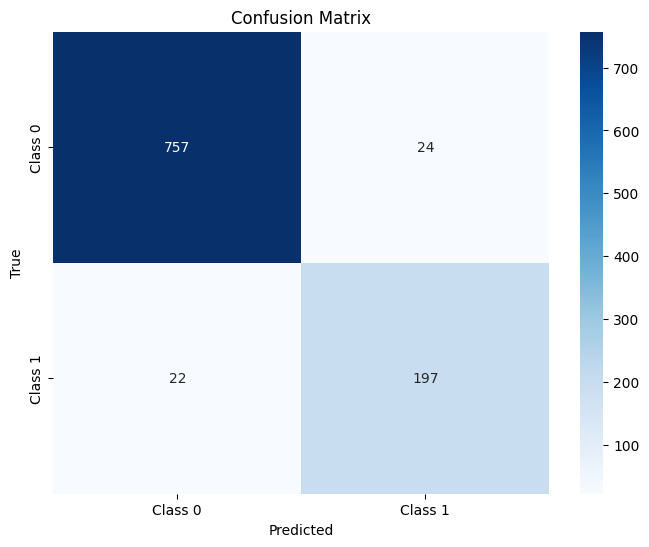

In [31]:
class_labels = ["Class 0", "Class 1"]  # Replace with your actual class labels if needed

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [18]:
!pip install efficientnet

In [19]:
import efficientnet.tfkeras as efn

In [34]:
base_model = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Optionally freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
model = Sequential([
    Input(shape=(256, 256, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')  # Change the number of units according to your task
])
model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Print model summary
model.summary()

16804768/16804768 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnet-b0 (Functional)    │ (None, 8, 8, 1280)     │     4,049,564 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,757 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,564 (15.45 MB)

In [35]:
history = model.fit(images, labels,
                          epochs=10,
                          batch_size=32,
                          validation_data=(new_images, new_labels))

Epoch 1/10
  3/125 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.7569 - loss: 0.6304   

W0000 00:00:1714024485.800004     150 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8803 - loss: 0.2923

W0000 00:00:1714024499.437174     147 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 55s 175ms/step - accuracy: 0.8807 - loss: 0.2912 - val_accuracy: 0.9340 - val_loss: 0.1660
Epoch 2/10
  2/125 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9453 - loss: 0.1464  

W0000 00:00:1714024507.579074     147 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.9343 - loss: 0.1672 - val_accuracy: 0.9600 - val_loss: 0.1054
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.9510 - loss: 0.1167 - val_accuracy: 0.9660 - val_loss: 0.0876
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.9586 - loss: 0.0997 - val_accuracy: 0.9360 - val_loss: 0.1562
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.9598 - loss: 0.0988 - val_accuracy: 0.9720 - val_loss: 0.0812
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.9584 - loss: 0.0975 - val_accuracy: 0.9670 - val_loss: 0.0855
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.9710 - loss: 0.0780 - val_accuracy: 0.9500 - val_loss: 0.1250
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.9647 - loss: 0.0887 - val_accuracy: 0.9720 - val_loss: 0.0811
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.9749 - loss: 0.0671 - val_accuracy: 0.97

In [36]:
test_loss, test_accuracy =model.evaluate(new_images, new_labels)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9730 - loss: 0.0691
Test Loss: 0.07134818285703659
Test Accuracy: 0.972000002861023


In [37]:
y_pred_probs = model.predict(new_images)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred_probs > 0.5).astype(int)

# Convert test labels to binary format (0: Normal, 1: Tuberculosis)
test_labels_binary = (new_labels > 0.5).astype(int)
classification_metrics = classification_report(test_labels_binary, y_pred_binary)
print("Classification Report:")
print(classification_metrics)

# Confusion matrix
conf_matrix = confusion_matrix(test_labels_binary, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

 5/32 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step

W0000 00:00:1714024588.642054     150 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       781
           1       0.96      0.91      0.93       219

    accuracy                           0.97      1000
   macro avg       0.97      0.95      0.96      1000
weighted avg       0.97      0.97      0.97      1000

Confusion Matrix:
[[773   8]
 [ 20 199]]


W0000 00:00:1714024595.117526     147 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


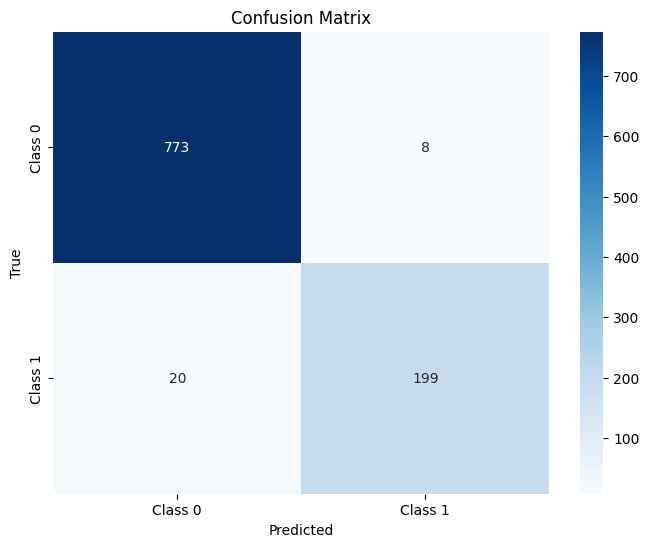

In [38]:
class_labels = ["Class 0", "Class 1"]  # Replace with your actual class labels if needed

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [20]:
base_model = efn.EfficientNetB2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Optionally freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
model = Sequential([
    Input(shape=(256, 256, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')  # Change the number of units according to your task
])
model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnet-b2 (Functional)    │ (None, 8, 8, 1408)     │     7,768,562 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       360,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,129,523 (31.01 MB)

 Trainable params: 360,961 (1.38 MB)

 Non-trainable params: 7,768,562 (29.63 MB)

In [21]:
history = model.fit(images, labels,
                          epochs=10,
                          batch_size=32,
                          validation_data=(new_images, new_labels))

Epoch 1/10
  1/125 ━━━━━━━━━━━━━━━━━━━━ 1:43:18 50s/step - accuracy: 0.4375 - loss: 0.7063

I0000 00:00:1714025641.983518     740 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714025642.049072     740 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8550 - loss: 0.3081

W0000 00:00:1714025659.748882     739 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 78s 228ms/step - accuracy: 0.8554 - loss: 0.3075 - val_accuracy: 0.9320 - val_loss: 0.1678
Epoch 2/10
  1/125 ━━━━━━━━━━━━━━━━━━━━ 18s 147ms/step - accuracy: 0.9375 - loss: 0.1537

W0000 00:00:1714025670.388734     739 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.9409 - loss: 0.1527 - val_accuracy: 0.9510 - val_loss: 0.1294
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.9504 - loss: 0.1283 - val_accuracy: 0.9470 - val_loss: 0.1406
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.9543 - loss: 0.1110 - val_accuracy: 0.9580 - val_loss: 0.1136
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.9504 - loss: 0.1200 - val_accuracy: 0.9540 - val_loss: 0.1198
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.9581 - loss: 0.0990 - val_accuracy: 0.9590 - val_loss: 0.1164
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.9637 - loss: 0.0889 - val_accuracy: 0.9580 - val_loss: 0.1148
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.9638 - loss: 0.0846 - val_accuracy: 0.9660 - val_loss: 0.0992
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.9711 - loss: 0.0731 - val_accurac

In [22]:
test_loss, test_accuracy =model.evaluate(new_images, new_labels)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9649 - loss: 0.1008
Test Loss: 0.0980171337723732
Test Accuracy: 0.9629999995231628


In [23]:
y_pred_probs = model.predict(new_images)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred_probs > 0.5).astype(int)

# Convert test labels to binary format (0: Normal, 1: Tuberculosis)
test_labels_binary = (new_labels > 0.5).astype(int)
classification_metrics = classification_report(test_labels_binary, y_pred_binary)
print("Classification Report:")
print(classification_metrics)

# Confusion matrix
conf_matrix = confusion_matrix(test_labels_binary, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

 4/32 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step

W0000 00:00:1714025777.140048     739 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 286ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       781
           1       0.93      0.89      0.91       219

    accuracy                           0.96      1000
   macro avg       0.95      0.94      0.95      1000
weighted avg       0.96      0.96      0.96      1000

Confusion Matrix:
[[767  14]
 [ 23 196]]


W0000 00:00:1714025785.989419     739 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


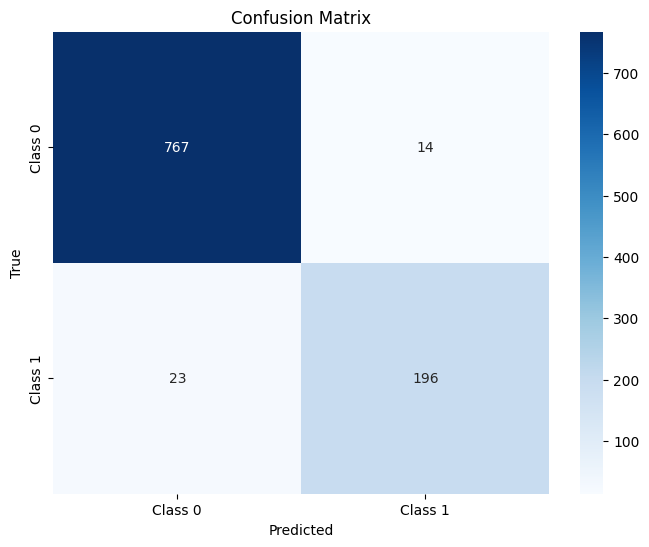

In [24]:
class_labels = ["Class 0", "Class 1"]  # Replace with your actual class labels if needed

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()